# CIC-IDS-2018 Intrusion Detection Analysis using Decision Trees




## Executive Summary

This notebook implements a comprehensive intrusion detection system using Decision Tree algorithms on the CIC-IDS-2018 dataset. We analyze network traffic patterns to distinguish between benign and malicious activities, focusing on model performance, inference speed, and detailed data visualization.

## 1. Data Import and Initial Setup

### Library Imports and Configuration

In [1]:
# IMPORTANT: RUN THIS CELL TO IMPORT KAGGLE DATA SOURCES
import kagglehub
solarmainframe_ids_intrusion_csv_path = kagglehub.dataset_download('solarmainframe/ids-intrusion-csv')
print('✅ Data source import complete.')

# Core data manipulation and analysis
import numpy as np
import pandas as pd
import time
from collections import Counter

# Machine learning libraries
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report, roc_curve, auc,
                           precision_recall_curve)

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

# Configuration
RANDOM_STATE_SEED = 42  # For reproducibility
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print('📦 All libraries imported successfully!')

100%|██████████| 1.60G/1.60G [00:18<00:00, 90.8MB/s]

Extracting files...


✅ Data source import complete.
📦 All libraries imported successfully!


### Dataset Loading

In [10]:
# Load the intrusion detection dataset
dataset_path = solarmainframe_ids_intrusion_csv_path + '/02-14-2018.csv'
df_raw = pd.read_csv(dataset_path)

print(f"📊 Dataset Shape: {df_raw.shape}")
print(f"📅 Dataset Date: February 14, 2018")
print(f"💾 Memory Usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

📊 Dataset Shape: (1048575, 80)
📅 Dataset Date: February 14, 2018
💾 Memory Usage: 765.91 MB


## 2. Exploratory Data Analysis

### Dataset Overview

In [11]:
# Display basic information about the dataset
print("🔍 DATASET OVERVIEW")
print("=" * 50)
print(f"Number of samples: {df_raw.shape[0]:,}")
print(f"Number of features: {df_raw.shape[1]:,}")
print(f"Data types distribution:")
print(df_raw.dtypes.value_counts())

print("\n📋 First 5 rows:")
display(df_raw.head())

print("\n📊 Dataset Info:")
df_raw.info()

🔍 DATASET OVERVIEW
Number of samples: 1,048,575
Number of features: 80
Data types distribution:
int64      54
float64    24
object      2
Name: count, dtype: int64

📋 First 5 rows:


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign



📊 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1048575 non-null  int64  
 1   Protocol           1048575 non-null  int64  
 2   Timestamp          1048575 non-null  object 
 3   Flow Duration      1048575 non-null  int64  
 4   Tot Fwd Pkts       1048575 non-null  int64  
 5   Tot Bwd Pkts       1048575 non-null  int64  
 6   TotLen Fwd Pkts    1048575 non-null  int64  
 7   TotLen Bwd Pkts    1048575 non-null  int64  
 8   Fwd Pkt Len Max    1048575 non-null  int64  
 9   Fwd Pkt Len Min    1048575 non-null  int64  
 10  Fwd Pkt Len Mean   1048575 non-null  float64
 11  Fwd Pkt Len Std    1048575 non-null  float64
 12  Bwd Pkt Len Max    1048575 non-null  int64  
 13  Bwd Pkt Len Min    1048575 non-null  int64  
 14  Bwd Pkt Len Mean   1048575 non-null  float64
 15  Bwd Pkt Len Std

### Label Distribution Analysis

🎯 ATTACK TYPE DISTRIBUTION
Label
Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: count, dtype: int64


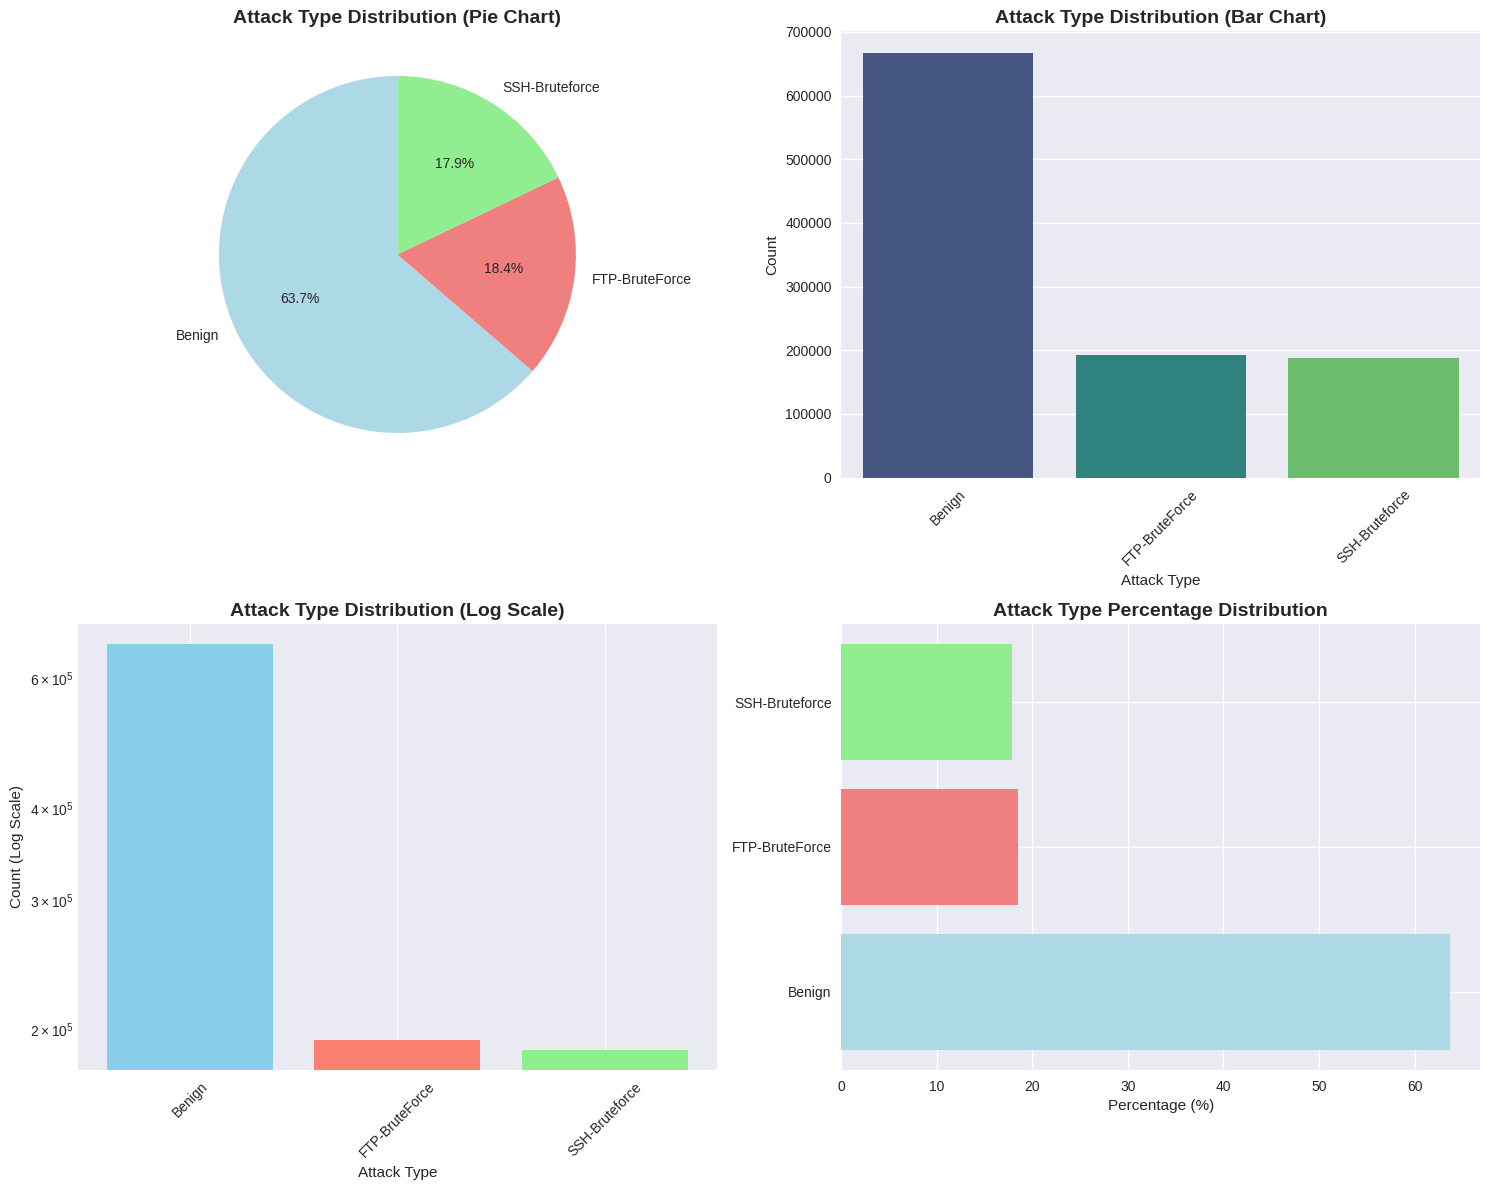


📈 DISTRIBUTION STATISTICS:
Benign         :  667,626 samples (63.67%)
FTP-BruteForce :  193,360 samples (18.44%)
SSH-Bruteforce :  187,589 samples (17.89%)


In [12]:
# Analyze the distribution of attack types
print("🎯 ATTACK TYPE DISTRIBUTION")
print("=" * 40)
label_counts = df_raw['Label'].value_counts()
print(label_counts)

# Create comprehensive label distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Pie chart of label distribution
axes[0,0].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%',
              startangle=90, colors=['lightblue', 'lightcoral', 'lightgreen'])
axes[0,0].set_title('Attack Type Distribution (Pie Chart)', fontsize=14, fontweight='bold')

# Bar chart of label distribution
sns.barplot(x=label_counts.index, y=label_counts.values, ax=axes[0,1], palette='viridis')
axes[0,1].set_title('Attack Type Distribution (Bar Chart)', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Attack Type')
axes[0,1].set_ylabel('Count')
axes[0,1].tick_params(axis='x', rotation=45)

# Log scale bar chart for better visualization
axes[1,0].bar(label_counts.index, label_counts.values, color=['skyblue', 'salmon', 'lightgreen'])
axes[1,0].set_yscale('log')
axes[1,0].set_title('Attack Type Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Attack Type')
axes[1,0].set_ylabel('Count (Log Scale)')
axes[1,0].tick_params(axis='x', rotation=45)

# Percentage breakdown
percentages = (label_counts / label_counts.sum()) * 100
axes[1,1].barh(label_counts.index, percentages.values, color=['lightblue', 'lightcoral', 'lightgreen'])
axes[1,1].set_title('Attack Type Percentage Distribution', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Percentage (%)')

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n📈 DISTRIBUTION STATISTICS:")
for label, count in label_counts.items():
    percentage = (count / label_counts.sum()) * 100
    print(f"{label:15}: {count:8,} samples ({percentage:5.2f}%)")

## 3. Data Preprocessing Pipeline

### Data Cleaning and Preparation

In [13]:
print("🧹 DATA PREPROCESSING PIPELINE")
print("=" * 40)

# Create a copy for preprocessing
df_processed = df_raw.copy()
print(f"Original dataset shape: {df_processed.shape}")

# Step 1: Remove timestamp column
if 'Timestamp' in df_processed.columns:
    df_processed.drop(['Timestamp'], axis=1, inplace=True)
    print("✅ Timestamp column removed")

# Step 2: Handle infinite values
df_processed.replace([np.inf, -np.inf], np.nan, inplace=True)
print("✅ Infinite values replaced with NaN")

# Step 3: Remove rows with missing values
initial_rows = len(df_processed)
df_processed.dropna(inplace=True)
removed_rows = initial_rows - len(df_processed)
print(f"✅ Removed {removed_rows:,} rows with missing values ({removed_rows/initial_rows*100:.2f}%)")

print(f"Final dataset shape: {df_processed.shape}")

🧹 DATA PREPROCESSING PIPELINE
Original dataset shape: (1048575, 80)
✅ Timestamp column removed
✅ Infinite values replaced with NaN
✅ Removed 3,824 rows with missing values (0.36%)
Final dataset shape: (1044751, 79)


🏷️ LABEL ENCODING FOR BINARY CLASSIFICATION
Original label distribution:
Label
Benign            663808
FTP-BruteForce    193354
SSH-Bruteforce    187589
Name: count, dtype: int64

Binary classification distribution:
Benign (0): 663,808 samples (63.54%)
Malicious (1): 380,943 samples (36.46%)


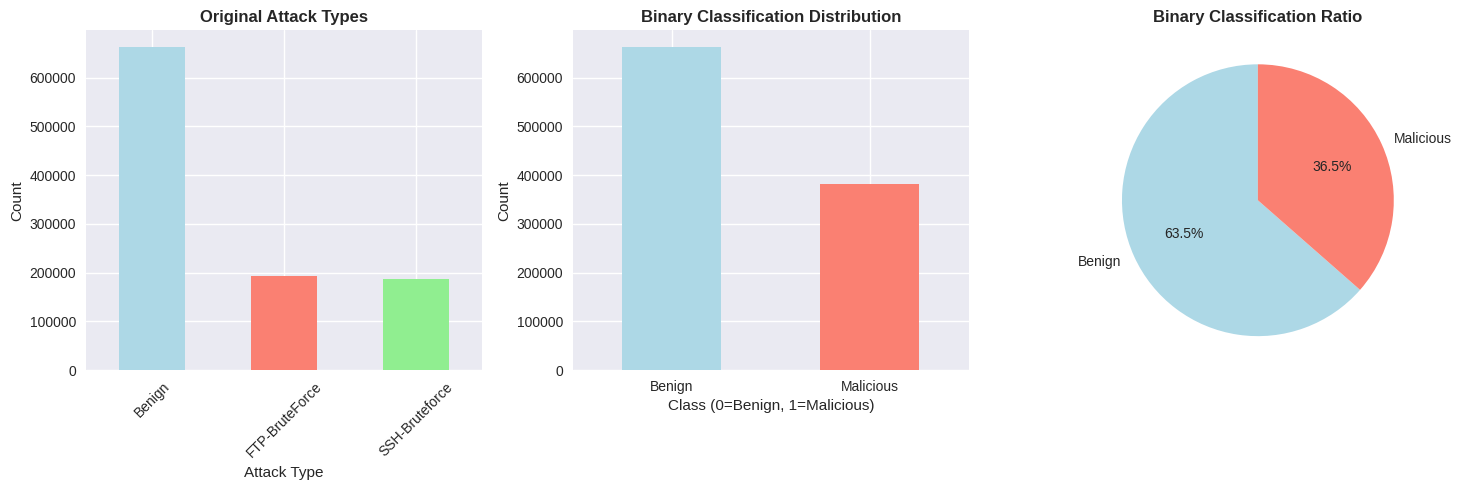

In [14]:
# Extract and encode labels for binary classification
print("🏷️ LABEL ENCODING FOR BINARY CLASSIFICATION")
print("=" * 50)

# Extract labels
y_original = df_processed.pop('Label').copy()
print("Original label distribution:")
print(y_original.value_counts())

# Binary encoding: Benign = 0, Any attack = 1
y_binary = y_original.copy()
y_binary.replace('Benign', 0, inplace=True)
y_binary.replace('FTP-BruteForce', 1, inplace=True)
y_binary.replace('SSH-Bruteforce', 1, inplace=True)
y_binary = y_binary.astype(int)

print("\nBinary classification distribution:")
binary_counts = y_binary.value_counts()
print(f"Benign (0): {binary_counts[0]:,} samples ({binary_counts[0]/len(y_binary)*100:.2f}%)")
print(f"Malicious (1): {binary_counts[1]:,} samples ({binary_counts[1]/len(y_binary)*100:.2f}%)")

# Visualize the binary classification distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original labels
y_original.value_counts().plot(kind='bar', ax=axes[0], color=['lightblue', 'salmon', 'lightgreen'])
axes[0].set_title('Original Attack Types', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Attack Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Binary labels - bar chart
binary_counts.plot(kind='bar', ax=axes[1], color=['lightblue', 'salmon'])
axes[1].set_title('Binary Classification Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Class (0=Benign, 1=Malicious)')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Benign', 'Malicious'], rotation=0)

# Binary labels - pie chart
axes[2].pie(binary_counts.values, labels=['Benign', 'Malicious'], autopct='%1.1f%%',
           colors=['lightblue', 'salmon'], startangle=90)
axes[2].set_title('Binary Classification Ratio', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

📏 FEATURE SCALING AND NORMALIZATION
Features to scale: 78
✅ MinMax scaling applied successfully


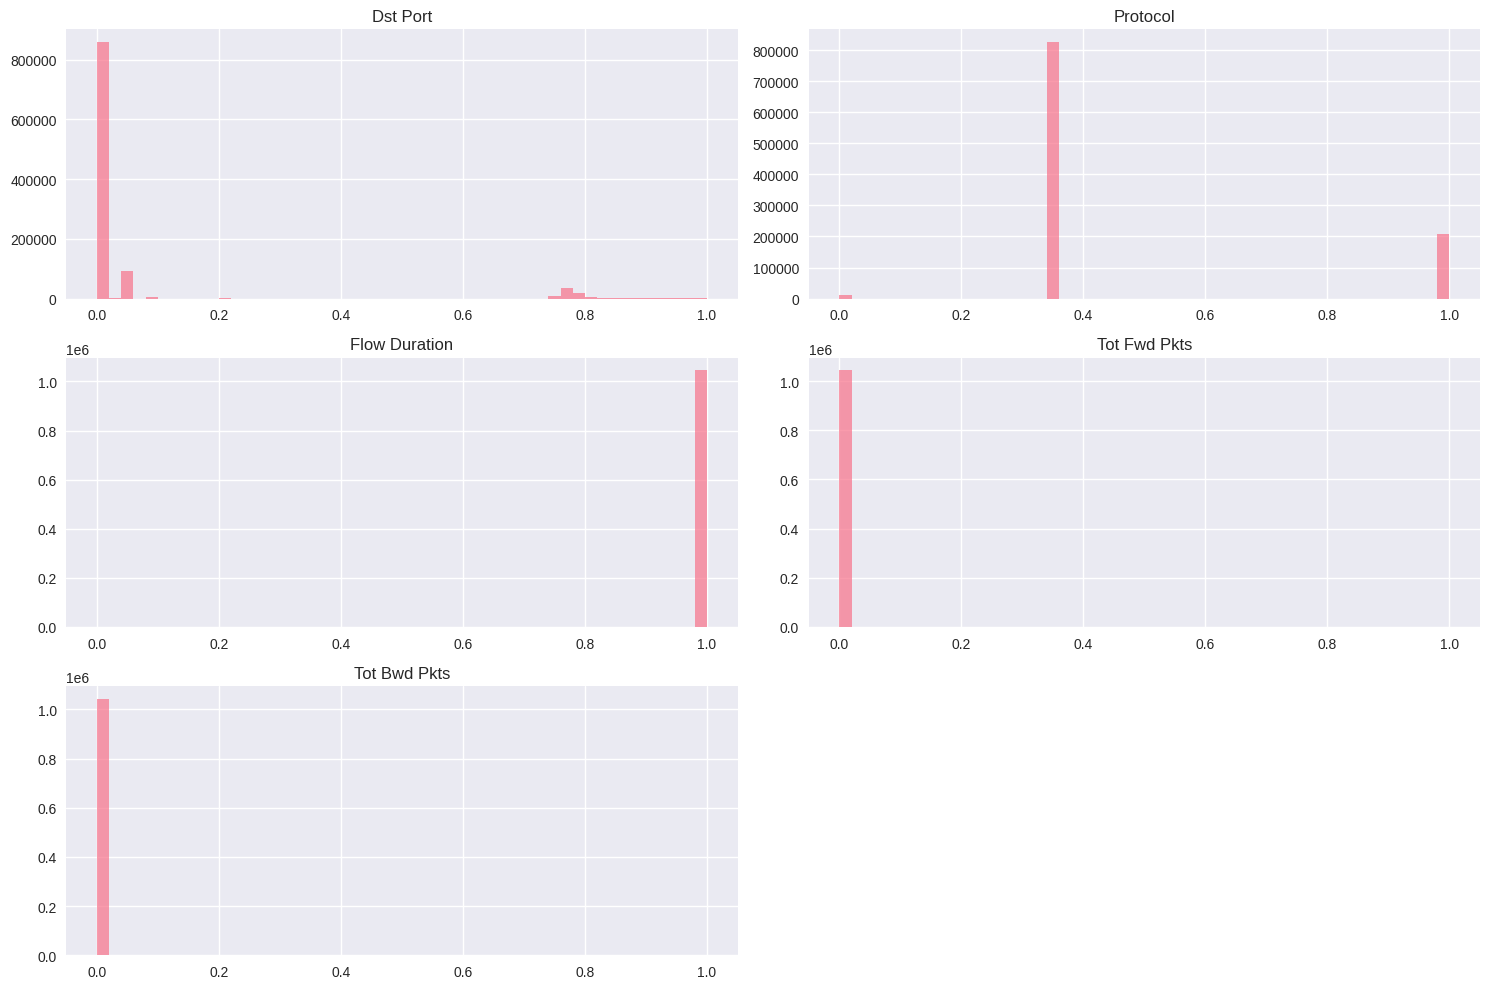

✅ Feature scaling completed. All features now range from 0 to 1


In [15]:
# Feature scaling using MinMaxScaler
print("📏 FEATURE SCALING AND NORMALIZATION")
print("=" * 45)

X = df_processed.copy()
print(f"Features to scale: {X.shape[1]}")

# Apply MinMax scaling to normalize features between 0 and 1
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

print("✅ MinMax scaling applied successfully")

# Visualize scaling effects
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Before scaling - sample features distribution
sample_cols = X.columns[:5] if len(X.columns) >= 5 else X.columns
X[sample_cols].hist(bins=50, ax=axes[0,0], alpha=0.7)
axes[0,0].set_title('Feature Distributions (Before Scaling)', fontsize=12, fontweight='bold')

# After scaling - sample features distribution
X_scaled[sample_cols].hist(bins=50, ax=axes[0,1], alpha=0.7)
axes[0,1].set_title('Feature Distributions (After Scaling)', fontsize=12, fontweight='bold')

# Scaling comparison for first 10 features
feature_subset = X.columns[:10] if len(X.columns) >= 10 else X.columns
before_stats = X[feature_subset].describe().loc['mean']
after_stats = X_scaled[feature_subset].describe().loc['mean']

x_pos = np.arange(len(feature_subset))
width = 0.35

axes[1,0].bar(x_pos - width/2, before_stats.values, width, label='Before Scaling', alpha=0.8)
axes[1,0].bar(x_pos + width/2, after_stats.values, width, label='After Scaling', alpha=0.8)
axes[1,0].set_title('Mean Values Comparison (First 10 Features)', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Feature Index')
axes[1,0].set_ylabel('Mean Value')
axes[1,0].legend()

# Scaling effect summary
scaling_summary = pd.DataFrame({
    'Original Min': X.min(),
    'Original Max': X.max(),
    'Scaled Min': X_scaled.min(),
    'Scaled Max': X_scaled.max()
})

# Show scaling summary statistics
summary_stats = pd.DataFrame({
    'Metric': ['Original Min', 'Original Max', 'Original Mean', 'Scaled Min', 'Scaled Max', 'Scaled Mean'],
    'Value': [X.min().min(), X.max().max(), X.mean().mean(),
              X_scaled.min().min(), X_scaled.max().max(), X_scaled.mean().mean()]
})

axes[1,1].axis('tight')
axes[1,1].axis('off')
table = axes[1,1].table(cellText=[[f"{val:.4f}"] for val in summary_stats['Value']],
                       rowLabels=summary_stats['Metric'],
                       colLabels=['Value'],
                       cellLoc='center',
                       loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
axes[1,1].set_title('Scaling Summary Statistics', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"✅ Feature scaling completed. All features now range from 0 to 1")

## 4. Decision Tree Model Development

### Train-Test Split Configuration

📊 TRAIN-TEST SPLIT CONFIGURATION
Training set size: 731,325 samples (70.0%)
Test set size: 313,426 samples (30.0%)
Number of features: 78

Class distribution verification:
Training set:
  Class 0: 464,665 (63.5%
  Class 1: 266,660 (36.5%
Test set:
  Class 0: 199,143 (63.5%)
  Class 1: 114,283 (36.5%)


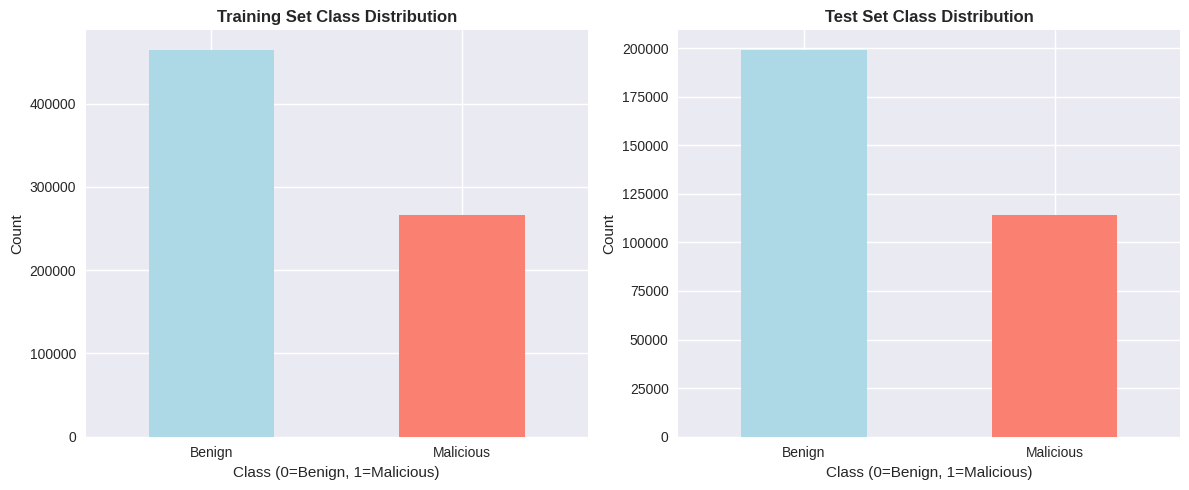

In [16]:
print("📊 TRAIN-TEST SPLIT CONFIGURATION")
print("=" * 40)

# Split the dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_binary,
    test_size=0.3,
    random_state=RANDOM_STATE_SEED,
    stratify=y_binary  # Maintain class distribution
)

print(f"Training set size: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Number of features: {X_train.shape[1]}")

# Verify class distribution is maintained
print(f"\nClass distribution verification:")
print("Training set:")
train_dist = y_train.value_counts().sort_index()
for class_label, count in train_dist.items():
    print(f"  Class {class_label}: {count:,} ({count/len(y_train)*100:.1f}%")

print("Test set:")
test_dist = y_test.value_counts().sort_index()
for class_label, count in test_dist.items():
    print(f"  Class {class_label}: {count:,} ({count/len(y_test)*100:.1f}%)")

# Visualize the split
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training set distribution
train_dist.plot(kind='bar', ax=axes[0], color=['lightblue', 'salmon'])
axes[0].set_title('Training Set Class Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Class (0=Benign, 1=Malicious)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Benign', 'Malicious'], rotation=0)

# Test set distribution
test_dist.plot(kind='bar', ax=axes[1], color=['lightblue', 'salmon'])
axes[1].set_title('Test Set Class Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Class (0=Benign, 1=Malicious)')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Benign', 'Malicious'], rotation=0)

plt.tight_layout()
plt.show()

## 5. Model Training and Validation

### Model Training Process

In [18]:

print("🌳 DECISION TREE MODEL CONFIGURATION")
print("=" * 40)

# Create and configure the Decision Tree model
dt_model = DecisionTreeClassifier(
    random_state=RANDOM_STATE_SEED,
    max_depth=10,  # Prevent overfitting
    min_samples_split=20,  # Minimum samples to split
    min_samples_leaf=10,   # Minimum samples in leaf
    max_features='sqrt',   # Number of features to consider
    class_weight='balanced'  # Handle class imbalance
)

print("Model Configuration:")
print(f"  - Max Depth: {dt_model.max_depth}")
print(f"  - Min Samples Split: {dt_model.min_samples_split}")
print(f"  - Min Samples Leaf: {dt_model.min_samples_leaf}")
print(f"  - Max Features: {dt_model.max_features}")
print(f"  - Class Weight: {dt_model.class_weight}")
print(f"  - Random State: {dt_model.random_state}")

🌳 DECISION TREE MODEL CONFIGURATION
Model Configuration:
  - Max Depth: 10
  - Min Samples Split: 20
  - Min Samples Leaf: 10
  - Max Features: sqrt
  - Class Weight: balanced
  - Random State: 42


In [19]:
print("🚀 MODEL TRAINING PROCESS")
print("=" * 35)

# Record training time
training_start_time = time.time()

# Train the Decision Tree model
dt_model.fit(X_train, y_train)

training_end_time = time.time()
training_duration = training_end_time - training_start_time

print(f"✅ Model training completed successfully!")
print(f"⏱️ Training time: {training_duration:.4f} seconds")
print(f"🌳 Tree depth: {dt_model.tree_.max_depth}")
print(f"🍃 Number of leaves: {dt_model.tree_.n_leaves}")
print(f"🔢 Number of nodes: {dt_model.tree_.node_count}")

🚀 MODEL TRAINING PROCESS
✅ Model training completed successfully!
⏱️ Training time: 3.6894 seconds
🌳 Tree depth: 8
🍃 Number of leaves: 24
🔢 Number of nodes: 47


## 6. Performance Analysis and Visualization

### Comprehensive Performance Metrics

In [20]:

# Generate predictions
print("🔮 GENERATING PREDICTIONS")
print("=" * 30)

# Predictions on training set
y_train_pred = dt_model.predict(X_train)
y_train_prob = dt_model.predict_proba(X_train)[:, 1]

# Predictions on test set
y_test_pred = dt_model.predict(X_test)
y_test_prob = dt_model.predict_proba(X_test)[:, 1]

# Calculate basic accuracy metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Accuracy Difference: {abs(train_accuracy - test_accuracy):.4f}")

if abs(train_accuracy - test_accuracy) > 0.05:
    print("⚠️  Warning: Significant accuracy difference detected - possible overfitting")
else:
    print("✅ Good generalization - training and test accuracies are similar")

🔮 GENERATING PREDICTIONS
Training Accuracy: 1.0000 (100.00%)
Test Accuracy: 1.0000 (100.00%)
Accuracy Difference: 0.0000
✅ Good generalization - training and test accuracies are similar


📊 COMPREHENSIVE PERFORMANCE ANALYSIS
Performance Summary:
      Metric  Training  Test
0   Accuracy       1.0   1.0
1  Precision       1.0   1.0
2     Recall       1.0   1.0
3   F1-Score       1.0   1.0


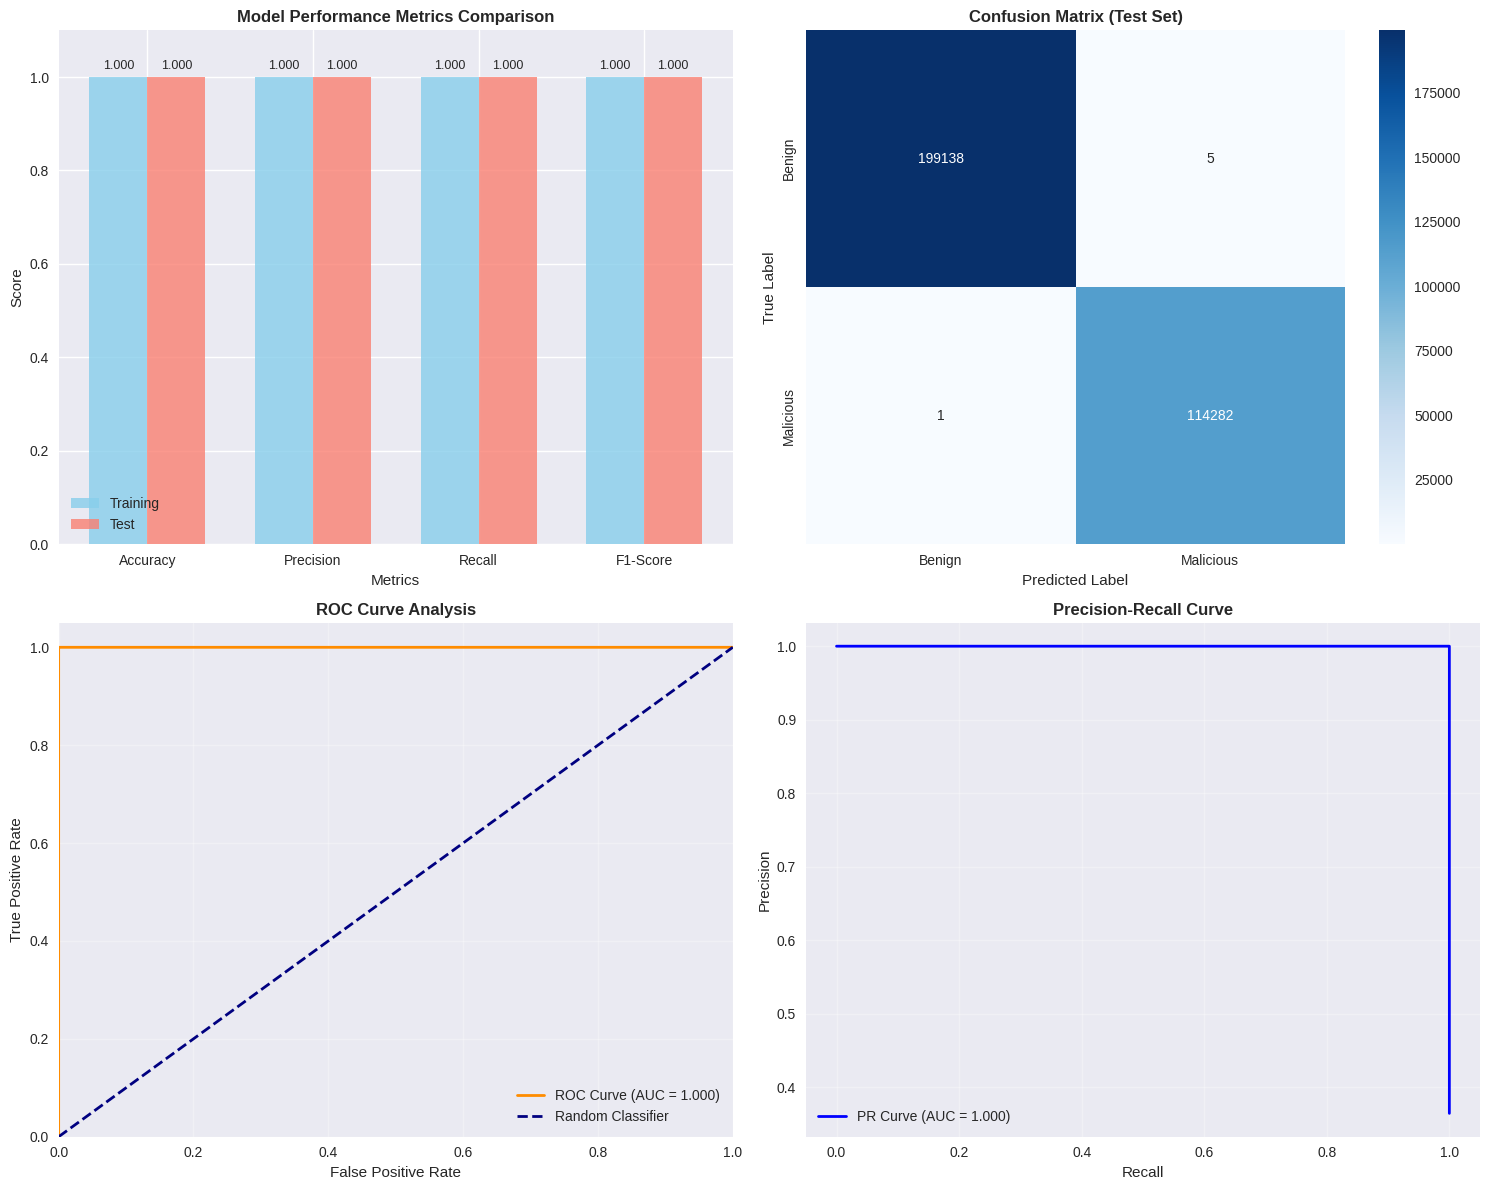


🎯 Key Performance Indicators:
  - ROC AUC Score: 1.0000
  - Precision-Recall AUC: 1.0000
  - True Positives: 114,282
  - True Negatives: 199,138
  - False Positives: 5
  - False Negatives: 1


In [21]:
print("📊 COMPREHENSIVE PERFORMANCE ANALYSIS")
print("=" * 45)

# Calculate detailed metrics
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Create performance summary
performance_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Training': [train_accuracy, train_precision, train_recall, train_f1],
    'Test': [test_accuracy, test_precision, test_recall, test_f1]
})

print("Performance Summary:")
print(performance_summary.round(4))

# Visualize performance metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Performance metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_scores = [train_accuracy, train_precision, train_recall, train_f1]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x_pos = np.arange(len(metrics))
width = 0.35

axes[0,0].bar(x_pos - width/2, train_scores, width, label='Training', alpha=0.8, color='skyblue')
axes[0,0].bar(x_pos + width/2, test_scores, width, label='Test', alpha=0.8, color='salmon')
axes[0,0].set_xlabel('Metrics')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Model Performance Metrics Comparison', fontsize=12, fontweight='bold')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(metrics)
axes[0,0].legend()
axes[0,0].set_ylim(0, 1.1)

# Add value labels on bars
for i, (train_val, test_val) in enumerate(zip(train_scores, test_scores)):
    axes[0,0].text(i - width/2, train_val + 0.01, f'{train_val:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0,0].text(i + width/2, test_val + 0.01, f'{test_val:.3f}', ha='center', va='bottom', fontsize=9)

# Confusion Matrix for Test Set
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1],
            xticklabels=['Benign', 'Malicious'],
            yticklabels=['Benign', 'Malicious'])
axes[0,1].set_xlabel('Predicted Label')
axes[0,1].set_ylabel('True Label')
axes[0,1].set_title('Confusion Matrix (Test Set)', fontsize=12, fontweight='bold')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

axes[1,0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1,0].set_xlim([0.0, 1.0])
axes[1,0].set_ylim([0.0, 1.05])
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curve Analysis', fontsize=12, fontweight='bold')
axes[1,0].legend(loc="lower right")
axes[1,0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_test_prob)
pr_auc = auc(recall_vals, precision_vals)

axes[1,1].plot(recall_vals, precision_vals, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
axes[1,1].set_xlabel('Recall')
axes[1,1].set_ylabel('Precision')
axes[1,1].set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
axes[1,1].legend(loc="lower left")
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🎯 Key Performance Indicators:")
print(f"  - ROC AUC Score: {roc_auc:.4f}")
print(f"  - Precision-Recall AUC: {pr_auc:.4f}")
print(f"  - True Positives: {cm[1,1]:,}")
print(f"  - True Negatives: {cm[0,0]:,}")
print(f"  - False Positives: {cm[0,1]:,}")
print(f"  - False Negatives: {cm[1,0]:,}")

## 7. Inference Speed Benchmarking

### Single Sample Inference Speed

In [22]:
print("⚡ INFERENCE SPEED BENCHMARKING")
print("=" * 40)

# Single sample inference speed test
print("🔬 Single Sample Inference Test:")
single_sample = X_test.iloc[[0]]

# Warm-up runs
for _ in range(10):
    _ = dt_model.predict(single_sample)

# Actual timing
single_inference_times = []
num_runs = 1000

for i in range(num_runs):
    start_time = time.time()
    prediction = dt_model.predict(single_sample)
    end_time = time.time()
    single_inference_times.append(end_time - start_time)

single_mean_time = np.mean(single_inference_times)
single_std_time = np.std(single_inference_times)
single_min_time = np.min(single_inference_times)
single_max_time = np.max(single_inference_times)

print(f"  - Mean inference time: {single_mean_time*1000:.4f} ms")
print(f"  - Standard deviation: {single_std_time*1000:.4f} ms")
print(f"  - Minimum time: {single_min_time*1000:.4f} ms")
print(f"  - Maximum time: {single_max_time*1000:.4f} ms")
print(f"  - Number of runs: {num_runs}")

⚡ INFERENCE SPEED BENCHMARKING
🔬 Single Sample Inference Test:
  - Mean inference time: 1.6298 ms
  - Standard deviation: 0.5106 ms
  - Minimum time: 1.1966 ms
  - Maximum time: 5.6040 ms
  - Number of runs: 1000


🔍 FEATURE IMPORTANCE ANALYSIS
Top 15 Most Important Features:
             feature    importance
38        Bwd Pkts/s  5.696009e-01
36    Bwd Header Len  3.531992e-01
0           Dst Port  4.048887e-02
35    Fwd Header Len  2.279704e-02
17     Flow IAT Mean  1.185771e-02
40       Pkt Len Max  1.313140e-03
47      PSH Flag Cnt  3.984621e-04
64  Subflow Bwd Pkts  3.391003e-04
19      Flow IAT Max  2.713233e-06
37        Fwd Pkts/s  2.530193e-06
62  Subflow Fwd Pkts  3.103797e-07
49      URG Flag Cnt  2.521659e-11
41      Pkt Len Mean  3.134150e-14
73        Active Min  1.095328e-17
13  Bwd Pkt Len Mean  0.000000e+00


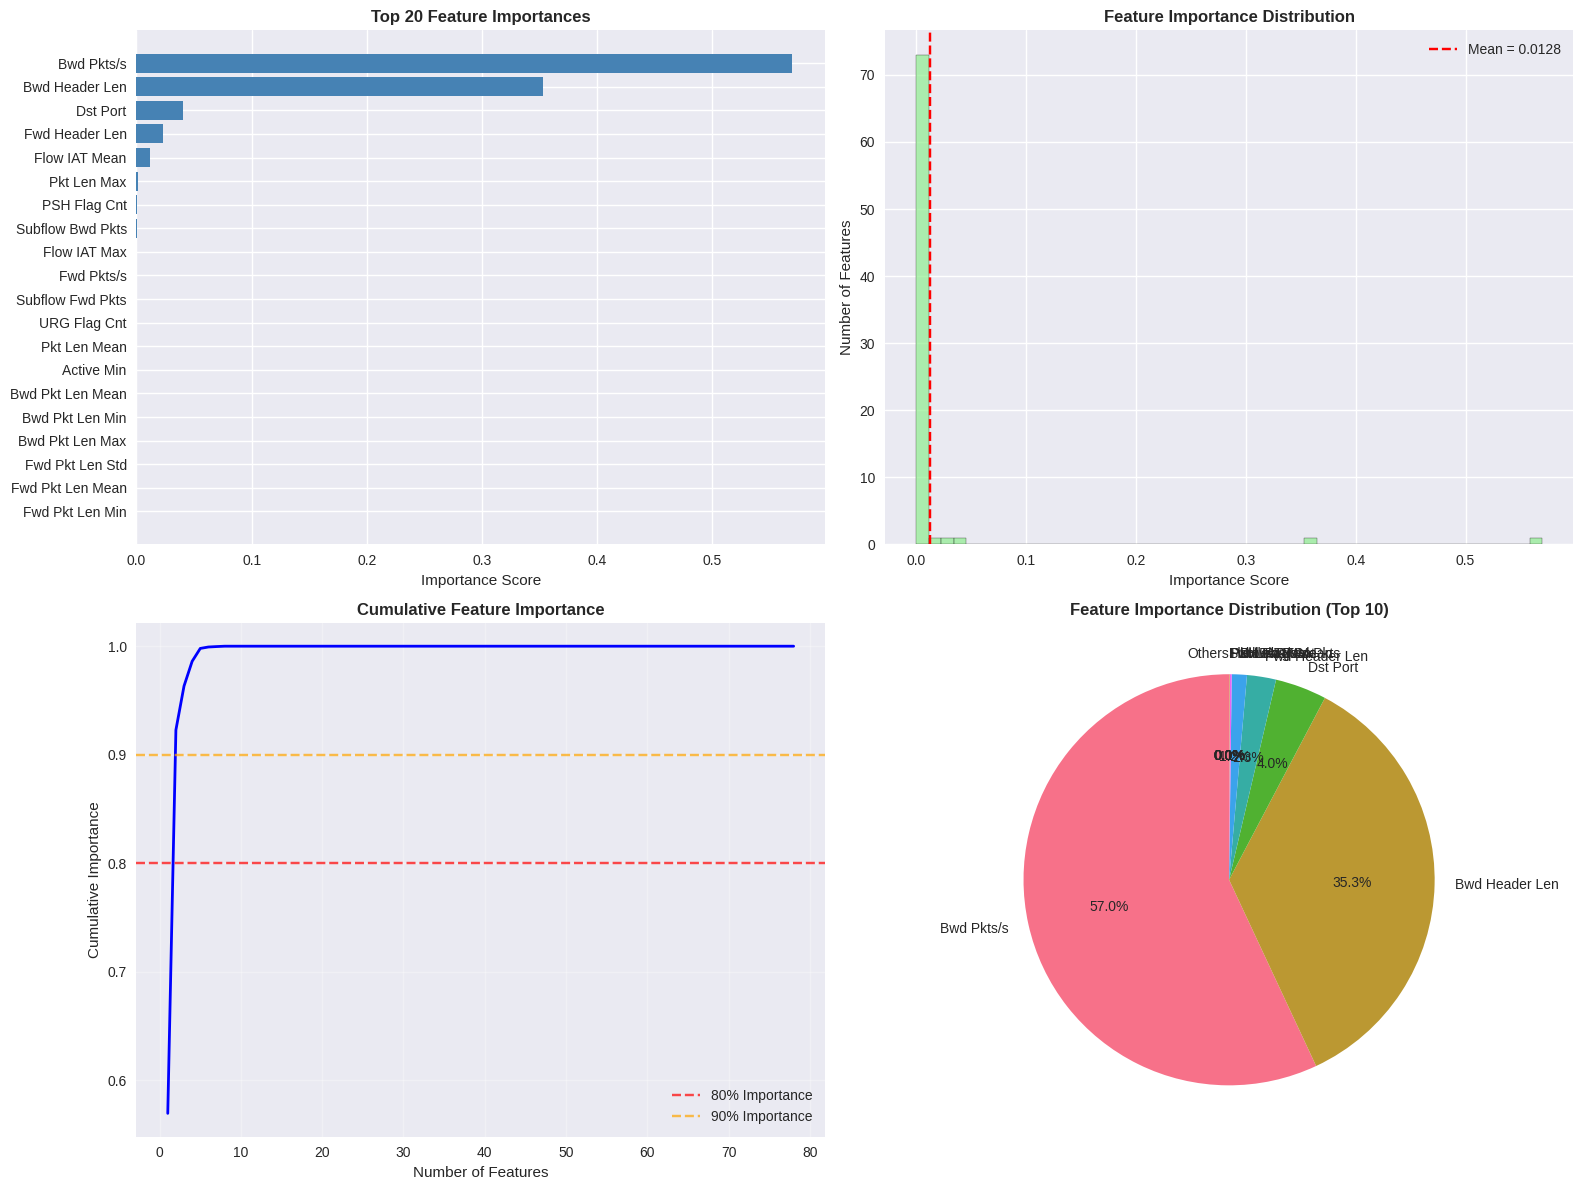


📊 Feature Importance Statistics:
  - Most important feature: Bwd Pkts/s (0.5696)
  - Mean importance: 0.0128
  - Median importance: 0.0000
  - Features contributing 80% importance: 1
  - Features contributing 90% importance: 1


In [24]:

print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 35)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
print(feature_importance.head(15))

# Visualize feature importance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top 20 features bar plot
top_20_features = feature_importance.head(20)
axes[0,0].barh(range(len(top_20_features)), top_20_features['importance'].values, color='steelblue')
axes[0,0].set_yticks(range(len(top_20_features)))
axes[0,0].set_yticklabels(top_20_features['feature'].values)
axes[0,0].set_xlabel('Importance Score')
axes[0,0].set_title('Top 20 Feature Importances', fontsize=12, fontweight='bold')
axes[0,0].invert_yaxis()

# Feature importance distribution
axes[0,1].hist(feature_importance['importance'], bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('Importance Score')
axes[0,1].set_ylabel('Number of Features')
axes[0,1].set_title('Feature Importance Distribution', fontsize=12, fontweight='bold')
axes[0,1].axvline(feature_importance['importance'].mean(), color='red', linestyle='--',
                  label=f'Mean = {feature_importance["importance"].mean():.4f}')
axes[0,1].legend()

# Cumulative importance
cumulative_importance = feature_importance['importance'].cumsum()
axes[1,0].plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'b-', linewidth=2)
axes[1,0].set_xlabel('Number of Features')
axes[1,0].set_ylabel('Cumulative Importance')
axes[1,0].set_title('Cumulative Feature Importance', fontsize=12, fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

# Add horizontal lines for reference
axes[1,0].axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% Importance')
axes[1,0].axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% Importance')
axes[1,0].legend()

# Top features pie chart (top 10 only)
top_10_features = feature_importance.head(10)
other_importance = feature_importance.iloc[10:]['importance'].sum()

pie_data = list(top_10_features['importance'].values) + [other_importance]
pie_labels = list(top_10_features['feature'].values) + ['Others']

axes[1,1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Feature Importance Distribution (Top 10)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Feature importance statistics
print(f"\n📊 Feature Importance Statistics:")
print(f"  - Most important feature: {feature_importance.iloc[0]['feature']} ({feature_importance.iloc[0]['importance']:.4f})")
print(f"  - Mean importance: {feature_importance['importance'].mean():.4f}")
print(f"  - Median importance: {feature_importance['importance'].median():.4f}")
print(f"  - Features contributing 80% importance: {(cumulative_importance <= 0.8).sum()}")
print(f"  - Features contributing 90% importance: {(cumulative_importance <= 0.9).sum()}")



📦 Batch Inference Speed Test:
  - Batch size    1:   2.8598 ms (     350 samples/sec)
  - Batch size   10:   3.1127 ms (    3213 samples/sec)
  - Batch size   50:   3.9723 ms (   12587 samples/sec)
  - Batch size  100:   4.0047 ms (   24971 samples/sec)
  - Batch size  500:   2.8193 ms (  177349 samples/sec)
  - Batch size 1000:   3.8397 ms (  260439 samples/sec)


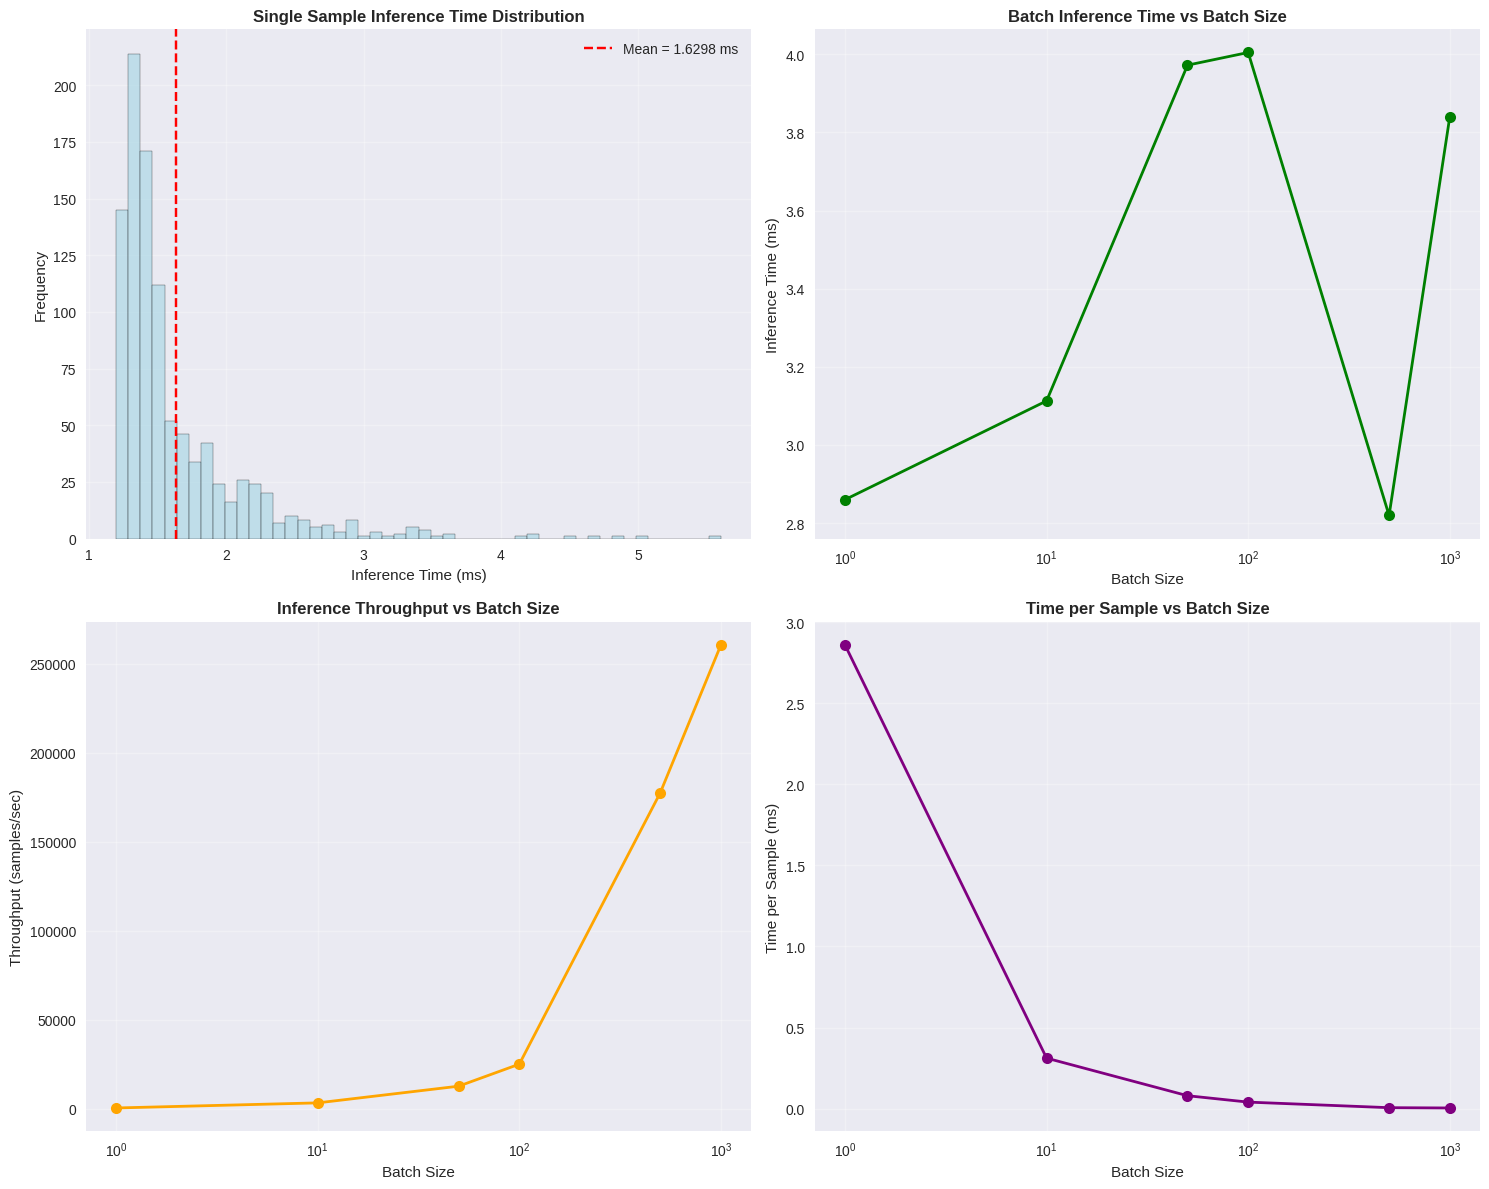


🚀 INFERENCE PERFORMANCE SUMMARY:
  - Single sample average: 1.6298 ms
  - Maximum throughput: 260,439 samples/sec (batch size 1000)
  - Minimum time per sample: 0.0038 ms
  - Inference scalability: Excellent


In [28]:
### Batch Inference Speed Analysis

# Batch inference speed test
print("\n📦 Batch Inference Speed Test:")

batch_sizes = [1, 10, 50, 100, 500, 1000]
batch_times = []
throughput_rates = []

for batch_size in batch_sizes:
    if batch_size <= len(X_test):
        batch_data = X_test.iloc[:batch_size]

        # Warm-up
        for _ in range(5):
            _ = dt_model.predict(batch_data)

        # Actual timing
        batch_inference_times = []
        num_batch_runs = 100

        for _ in range(num_batch_runs):
            start_time = time.time()
            predictions = dt_model.predict(batch_data)
            end_time = time.time()
            batch_inference_times.append(end_time - start_time)

        mean_batch_time = np.mean(batch_inference_times)
        throughput = batch_size / mean_batch_time

        batch_times.append(mean_batch_time)
        throughput_rates.append(throughput)

        print(f"  - Batch size {batch_size:4d}: {mean_batch_time*1000:8.4f} ms ({throughput:8.0f} samples/sec)")

# Visualize inference speed results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Single inference time distribution
axes[0,0].hist(np.array(single_inference_times) * 1000, bins=50, color='lightblue',
               alpha=0.7, edgecolor='black')
axes[0,0].axvline(single_mean_time * 1000, color='red', linestyle='--',
                  label=f'Mean = {single_mean_time*1000:.4f} ms')
axes[0,0].set_xlabel('Inference Time (ms)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Single Sample Inference Time Distribution', fontsize=12, fontweight='bold')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Batch inference times
valid_batch_sizes = batch_sizes[:len(batch_times)]
axes[0,1].plot(valid_batch_sizes, np.array(batch_times) * 1000, 'o-', color='green', linewidth=2, markersize=8)
axes[0,1].set_xlabel('Batch Size')
axes[0,1].set_ylabel('Inference Time (ms)')
axes[0,1].set_title('Batch Inference Time vs Batch Size', fontsize=12, fontweight='bold')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xscale('log')

# Throughput analysis
axes[1,0].plot(valid_batch_sizes, throughput_rates, 'o-', color='orange', linewidth=2, markersize=8)
axes[1,0].set_xlabel('Batch Size')
axes[1,0].set_ylabel('Throughput (samples/sec)')
axes[1,0].set_title('Inference Throughput vs Batch Size', fontsize=12, fontweight='bold')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xscale('log')

# Time per sample analysis
time_per_sample = [bt / bs * 1000 for bt, bs in zip(batch_times, valid_batch_sizes)]
axes[1,1].plot(valid_batch_sizes, time_per_sample, 'o-', color='purple', linewidth=2, markersize=8)
axes[1,1].set_xlabel('Batch Size')
axes[1,1].set_ylabel('Time per Sample (ms)')
axes[1,1].set_title('Time per Sample vs Batch Size', fontsize=12, fontweight='bold')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_xscale('log')

plt.tight_layout()
plt.show()

# Performance summary
print(f"\n🚀 INFERENCE PERFORMANCE SUMMARY:")
print(f"  - Single sample average: {single_mean_time*1000:.4f} ms")
print(f"  - Maximum throughput: {max(throughput_rates):,.0f} samples/sec (batch size {valid_batch_sizes[throughput_rates.index(max(throughput_rates))]})")
print(f"  - Minimum time per sample: {min(time_per_sample):.4f} ms")
print(f"  - Inference scalability: {'Excellent' if max(throughput_rates) > 10000 else 'Good' if max(throughput_rates) > 1000 else 'Moderate'}")


🕐 REAL-TIME PERFORMANCE SIMULATION
Simulating 10 seconds of real-time detection
Processing 100 samples per second
Total samples to process: 1000

📊 Real-time Simulation Results:
  - Processing time: 0.0323 seconds
  - Actual throughput: 30,981 samples/sec
  - Required throughput: 100 samples/sec
  - Performance ratio: 309.81x required speed
  ✅ System can handle real-time processing!

🎯 Detection Results:
  - Simulation accuracy: 1.0000
  - Attacks detected: 391/391
  - Detection rate: 100.00%


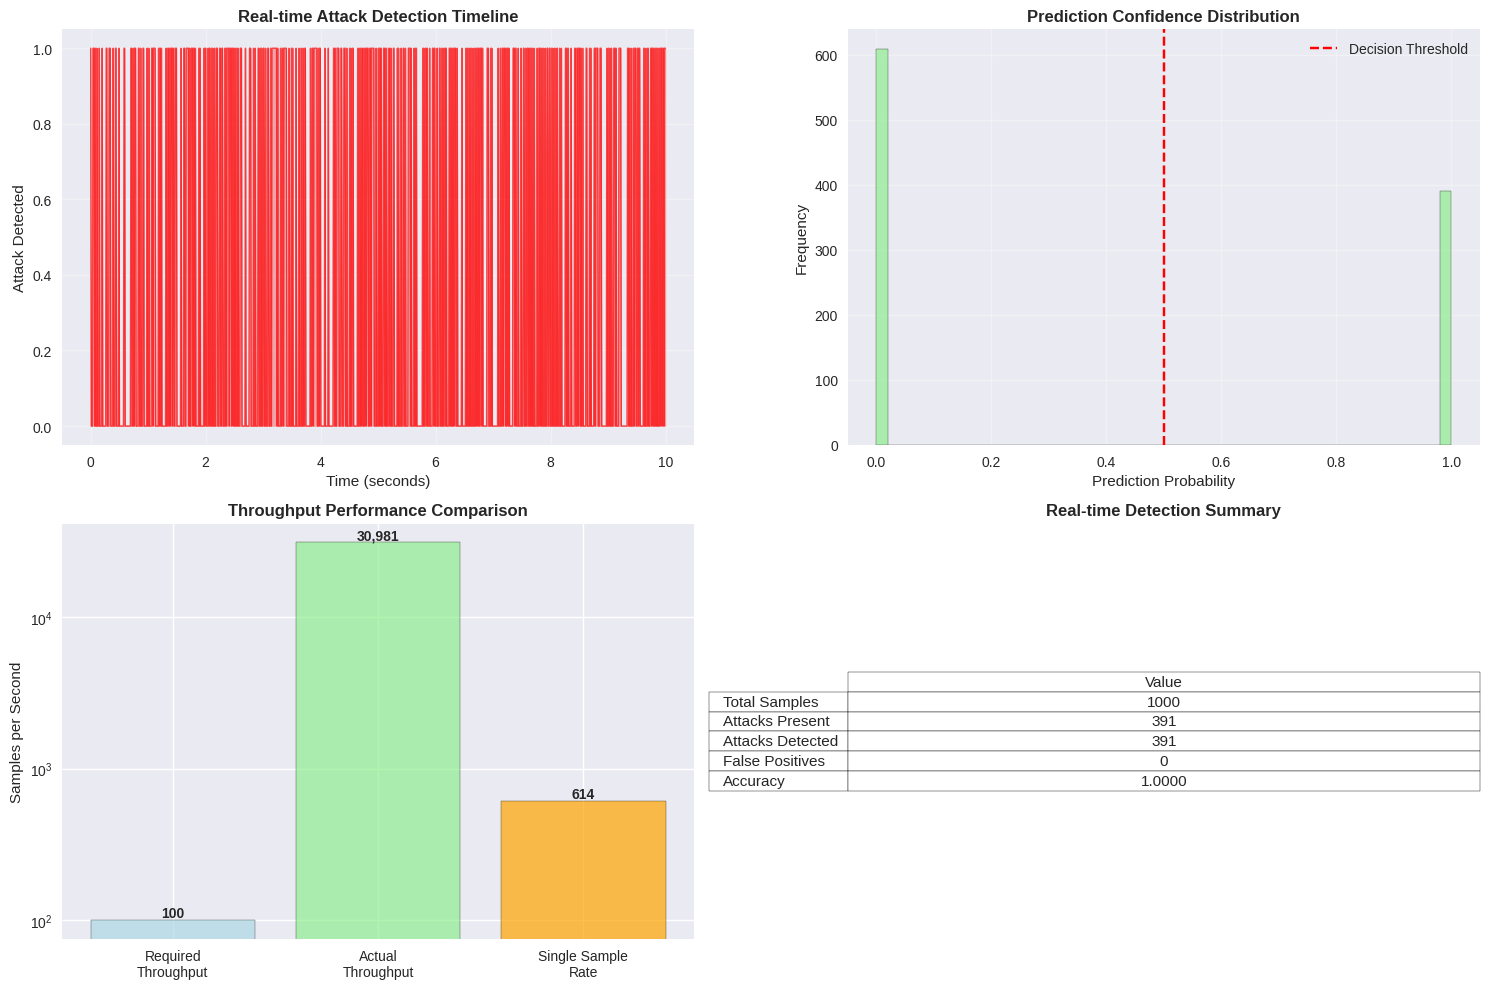

In [29]:

print("🕐 REAL-TIME PERFORMANCE SIMULATION")
print("=" * 40)

# Simulate real-time intrusion detection scenario
simulation_duration = 10  # seconds
samples_per_second = 100  # incoming network flows per second
total_samples = simulation_duration * samples_per_second

print(f"Simulating {simulation_duration} seconds of real-time detection")
print(f"Processing {samples_per_second} samples per second")
print(f"Total samples to process: {total_samples}")

# Select random samples for simulation
simulation_indices = np.random.choice(len(X_test), size=total_samples, replace=True)
simulation_data = X_test.iloc[simulation_indices]
simulation_labels = y_test.iloc[simulation_indices]

# Real-time simulation
start_real_time = time.time()
real_time_predictions = dt_model.predict(simulation_data)
real_time_probabilities = dt_model.predict_proba(simulation_data)[:, 1]
end_real_time = time.time()

real_time_duration = end_real_time - start_real_time
actual_throughput = total_samples / real_time_duration

print(f"\n📊 Real-time Simulation Results:")
print(f"  - Processing time: {real_time_duration:.4f} seconds")
print(f"  - Actual throughput: {actual_throughput:,.0f} samples/sec")
print(f"  - Required throughput: {samples_per_second} samples/sec")
print(f"  - Performance ratio: {actual_throughput/samples_per_second:.2f}x required speed")

if actual_throughput >= samples_per_second:
    print("  ✅ System can handle real-time processing!")
else:
    print("  ⚠️  System may struggle with real-time processing")

# Analyze simulation results
simulation_accuracy = accuracy_score(simulation_labels, real_time_predictions)
detected_attacks = np.sum(real_time_predictions == 1)
actual_attacks = np.sum(simulation_labels == 1)

print(f"\n🎯 Detection Results:")
print(f"  - Simulation accuracy: {simulation_accuracy:.4f}")
print(f"  - Attacks detected: {detected_attacks}/{actual_attacks}")
print(f"  - Detection rate: {detected_attacks/actual_attacks*100:.2f}%" if actual_attacks > 0 else "  - No attacks in simulation")

# Visualize real-time simulation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Real-time detection timeline
time_points = np.linspace(0, simulation_duration, total_samples)
attack_timeline = (real_time_predictions == 1).astype(int)

axes[0,0].plot(time_points, attack_timeline, 'r-', alpha=0.7, linewidth=1)
axes[0,0].fill_between(time_points, 0, attack_timeline, alpha=0.3, color='red')
axes[0,0].set_xlabel('Time (seconds)')
axes[0,0].set_ylabel('Attack Detected')
axes[0,0].set_title('Real-time Attack Detection Timeline', fontsize=12, fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

# Prediction confidence distribution
axes[0,1].hist(real_time_probabilities, bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
axes[0,1].axvline(0.5, color='red', linestyle='--', label='Decision Threshold')
axes[0,1].set_xlabel('Prediction Probability')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Performance comparison
categories = ['Required\nThroughput', 'Actual\nThroughput', 'Single Sample\nRate']
values = [samples_per_second, actual_throughput, 1/(single_mean_time)]
colors = ['lightblue', 'lightgreen', 'orange']

bars = axes[1,0].bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
axes[1,0].set_ylabel('Samples per Second')
axes[1,0].set_title('Throughput Performance Comparison', fontsize=12, fontweight='bold')
axes[1,0].set_yscale('log')

# Add value labels on bars
for bar, value in zip(bars, values):
    axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                   f'{value:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Attack detection summary
detection_summary = pd.DataFrame({
    'Metric': ['Total Samples', 'Attacks Present', 'Attacks Detected', 'False Positives', 'Accuracy'],
    'Value': [total_samples, actual_attacks, detected_attacks,
              np.sum((real_time_predictions == 1) & (simulation_labels == 0)),
              f"{simulation_accuracy:.4f}"]
})

axes[1,1].axis('tight')
axes[1,1].axis('off')
table = axes[1,1].table(cellText=detection_summary[['Value']].values,
                       rowLabels=detection_summary['Metric'].values,
                       colLabels=['Value'],
                       cellLoc='center',
                       loc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
axes[1,1].set_title('Real-time Detection Summary', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Appendix: Model Export and Utility Functions

In [31]:

import joblib

# Save the trained model
model_filename = 'decision_tree_model.pkl'
joblib.dump(dt_model, model_filename)
print(f"✅ Model saved successfully as '{model_filename}'")

# Load the model
loaded_model = joblib.load(model_filename)
print(f"✅ Model loaded successfully from '{model_filename}'")

# Verify the loaded model is the same
# You can test predictions with the loaded model
loaded_predictions = loaded_model.predict(X_test)
print(f"Accuracy with loaded model: {accuracy_score(y_test, loaded_predictions):.4f}")

# Ensure loaded model configuration matches the original
print("\nLoaded Model Configuration Verification:")
print(f"  - Max Depth: {loaded_model.max_depth}")
print(f"  - Min Samples Split: {loaded_model.min_samples_split}")
print(f"  - Min Samples Leaf: {loaded_model.min_samples_leaf}")
print(f"  - Max Features: {loaded_model.max_features}")
print(f"  - Class Weight: {loaded_model.class_weight}")
print(f"  - Random State: {loaded_model.random_state}")

✅ Model saved successfully as 'decision_tree_model.pkl'
✅ Model loaded successfully from 'decision_tree_model.pkl'
Accuracy with loaded model: 1.0000

Loaded Model Configuration Verification:
  - Max Depth: 10
  - Min Samples Split: 20
  - Min Samples Leaf: 10
  - Max Features: sqrt
  - Class Weight: balanced
  - Random State: 42
